# Site Adaptation

**Site adaptation** is a process in which long term time series of a modeled variable (i.e., solar irradiance) is improved in accuracy by using short term of observations of the variable (for instance, one year of ground measurements in solar irradiance). One of the site adaptation methods is Quantile Mapping. In this section, an example for site adaptation using this technique is presented.

***
<div style="text-align: right"> <i>Content by Jesús Polo</i> </div>



Let's import the required libraries for this example:


In [1]:
import numpy as np
import pandas as pd
import pvlib
from scipy import interpolate
import matplotlib.pyplot as plt

## Quantile mapping for site adaptation
Quantile mapping (QM) is a simple technique used in climate modeling and meteorology for correcting the distribution of a modeled parameter by comparing it against the empirical distribution of observations. The methodology consists of transforming the data into the probability domain (quantiles) and reverses the transformation using the cumulative distribution function (CDF) as an operator.

$$ y_c = CDF_0^{-1}[CDF_m(x_m)],$$

where $CDF_0$ and $CDF_m$ are the cumulative distribution functions of the observed and modeled data, respectively.

The function for correcting data using quantile mapping is 
*QuantileMappinBR(y_obs,y_mod)*, which has 2 inputs:
- *y_obs* :  an array with the observational data;
- *y_mod* :  an array with the modeled data to be corrected.

The function returns an array *y_cor*  of the same length of *y_mod* with the new modeled values that fits the cumulative distribution function of the observed values.

To implement QM, we also use an auxiliary function *ecdf* to empirically compute CDF. These functions implemented in Python would look like:

In [2]:
def ecdf(x): # empirical CDF computation
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def QuantileMappinBR(y_obs,y_mod): # Bias Removal using empirical quantile mapping
    y_cor = y_mod
    x_obs,cdf_obs = ecdf(y_obs)
    x_mod,cdf_mod = ecdf(y_mod)
    # Translate data to the quantile domain, apply the CDF operator
    cdf = interpolate.interp1d(x_mod,cdf_mod,kind='nearest',fill_value='extrapolate')
    qtile = cdf(y_mod)
    # Apply de CDF^-1 operator to reverse the operation to radiation domain
    cdfinv = interpolate.interp1d(cdf_obs,x_obs,kind='nearest',fill_value='extrapolate')
    y_cor = cdfinv(qtile)
    return y_cor

## Example of site adaptation

In the example for the implementation of site adaptation, ground-based data for 2015 in Tamanrasset BSRN station in Algeria are used as observations and [PVGIS](https://ec.europa.eu/jrc/en/pvgis) hourly data from 2005 to 2015 are used as modeled data.

Let's query the data from those stations. First for the BSRN station:

```{admonition} BSRN credentials
You will need to have credentials for the BSRN FTP server in order to run the query of data from a BSRN station. It is freely available under request. Check the [BSRN site](https://bsrn.awi.de/).
```


In [5]:
# Get One year of observations of solar radiation 
data_obs, metadata = pvlib.iotools.get_bsrn(  
    start = pd.Timestamp(2015,1,1), end=pd.Timestamp(2015,12,1),   
    station ='tam', username=bsrn_username, password=bsrn_password)  
# Extract positive values of GHI observations
ghi_obs = data_obs.ghi
ghi_obs[ghi_obs<0]=0

# Resample to hourly means
ghi_hr = ghi_obs.resample('60min').mean()

Now, the PVGIS modeled data:

In [6]:
# Get modeled data from pvgis
latitude = metadata['latitude']
longitude = metadata['longitude']
# pvgis hourly data from 2005 to 2016
data_model = pvlib.iotools.get_pvgis_hourly(latitude, longitude, start=None, end=2015, raddatabase='PVGIS-SARAH',
                                    components=True, surface_tilt=0, surface_azimuth=0,
                                    outputformat='json', usehorizon=True, userhorizon=None,
                                    pvcalculation=False, peakpower=None, pvtechchoice='crystSi',
                                    mountingplace='free', loss=0, trackingtype=2, optimal_surface_tilt=False,
                                    optimalangles=False, url='https://re.jrc.ec.europa.eu/api/',
                                    map_variables=True, timeout=30)

# Estimate the GHI values from the data queried
dni = data_model[0].poa_direct.values
diff = data_model[0].poa_sky_diffuse.values
cosazen = np.cos((90-data_model[0].solar_elevation.values)*np.pi/180)
ghi = dni*cosazen+diff


We can now apply the site adaptation following the QM method:

In [7]:
# Site adaptation
ghi_adapted = QuantileMappinBR(ghi_hr,ghi)

data_model[0]['ghi'] = ghi
data_model[0]['ghi_adapted'] = ghi_adapted

We can visualize the results in a time-series:

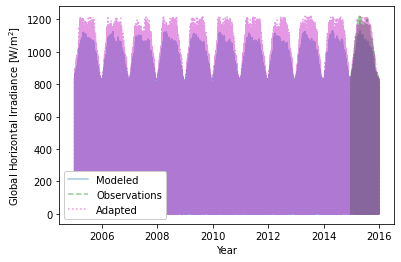

In [8]:
plt.plot(data_model[0].ghi,  alpha=0.4)
plt.plot(ghi_hr,color='green',linestyle='dashed', alpha=0.4)
plt.plot(data_model[0].ghi_adapted, color='m', linestyle='dotted', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
plt.legend(['Modeled','Observations','Adapted'], loc='lower left', framealpha=1)

Hourly values are a great number of datapoints. Thus, we can better see the effect of site adaptation for shorter timeseries, for example:

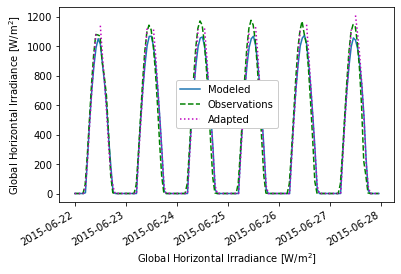

In [9]:
data_model[0].ghi['2015-06-22':'2015-06-27'].plot()
ghi_hr['2015-06-22':'2015-06-27'].plot(color='green',linestyle='dashed')
data_model[0].ghi_adapted['2015-06-22':'2015-06-27'].plot(color='m', linestyle='dotted')
plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
plt.xlabel('Global Horizontal Irradiance [W/m$^2$]')
plt.legend(['Modeled','Observations','Adapted'], framealpha=1)

The **effect of the QM technique** can be observed by observing the CDF of original and adapted GHI:

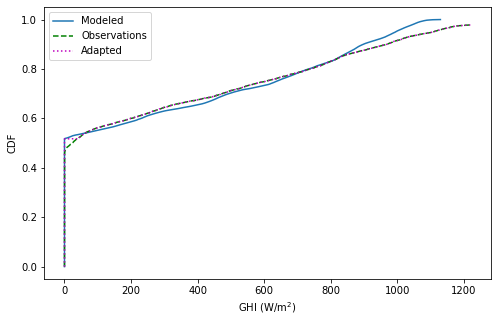

In [17]:
# Definition of variables to plot
x_obs,cdf_obs = ecdf(ghi_hr)
x_mod,cdf_mod = ecdf(ghi)
x_adp,cdf_adp = ecdf(ghi_adapted)

# Figure definition
plt.figure(figsize=(8, 5))
plt.plot(x_mod,cdf_mod)
plt.plot(x_obs,cdf_obs,c='g', linestyle='dashed')
plt.plot(x_adp,cdf_adp,c='m', linestyle='dotted')
plt.ylabel('CDF')
plt.xlabel('GHI (W/m$^2$)')
plt.legend(['Modeled','Observations','Adapted'])


With the CDF plot we can observe that the adapted timeseries resulted from the QM site adaptation method has higher agreement with the ground-based observations than the modeled satellite-based data.

## Section summary

This section has introduced site adaptation as a technique to adjust long-term satellite observations using short-term ground-based observations. The functions to implement site adaptation with the quantile mapping methods have been provided and an example of use has been illustrated.

***


## References

Polo, J., Wilbert, S., Ruiz-Arias, J.A., Meyer, R., Gueymard, C., Súri, M., Martín, L., Mieslinger, T., Blanc, P., Grant, I., Boland, J., Ineichen, P., Remund, J., Escobar, R., Troccoli, A., Sengupta, M., Nielsen, K.P., Renne, D., Geuder, N., Cebecauer, T., 2016. Preliminary survey on site-adaptation techniques for satellite-derived and reanalysis solar radiation datasets. Solar Energy 132, 25–37. [doi:10.1016/j.solener.2016.03.001](https://www.sciencedirect.com/science/article/pii/S0038092X16001754)

 

Polo, J., Fernández-Peruchena, C., Salamalikis, V., Mazorra-Aguiar, L., Turpin, M., Martín-Pomares, L., Kazantzidis, A., Blanc, P., Remund, J., 2020. Benchmarking on improvement and site-adaptation techniques for modeled solar radiation datasets. Solar Energy 201, 469–479. [doi:10.1016/j.solener.2020.03.040](https://www.sciencedirect.com/science/article/pii/S0038092X20302784)

 

Fernández-Peruchena, C.M., Polo, J., Martín, L., Mazorra, L., 2020. Site-Adaptation of Modeled Solar Radiation Data : The SiteAdapt Procedure. Remote Sensing 12, 1–17. [doi:10.3390/rs12132127](https://www.mdpi.com/2072-4292/12/13/2127)